mcu data: https://www.kaggle.com/pdunton/marvel-cinematic-universe-dialogue?select=mcu_subset.csv


dataset: https://www.kaggle.com/cosmos98/twitter-and-reddit-sentimental-analysis-dataset

In [80]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC, OneVsRest
from pyspark.ml.feature import HashingTF, Tokenizer, StopWordsRemover, RegexTokenizer, PCA, IndexToString, StringIndexer, VectorIndexer
from pyspark.mllib.regression import LabeledPoint
from IPython.display import Image
from pyspark.sql import SparkSession
import IPython
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd
from sklearn.naive_bayes import GaussianNB
import time

In [81]:
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Python Spark SQL basic example") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()
    return spark
spark = init_spark()

# 1. Data Preparation

![display image](https://media.giphy.com/media/3oxHQjRHcp4w9oi24M/giphy.gif)

In [82]:
read_csv = spark.read.csv('data/Twitter_Data_utf8.csv', inferSchema=True, header=True)

In [83]:
data = read_csv.select("clean_text", col("category").cast("Int").alias("label")).dropna().dropDuplicates().replace(-1,2).orderBy(rand()).limit(140000)

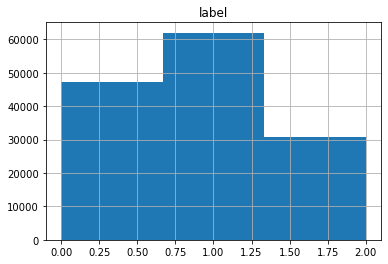

In [84]:
data_p = data.drop('clean_text').toPandas()
hist = data_p.hist(bins=3)

In [85]:

split = data.randomSplit([0.7, 0.3])
trainingData = split[0]
testingData = split[1]
print ("Training data has", split[0].count(), 'rows.')
print ("Testing data has", split[1].count(), 'rows.')

Training data has 97949 rows.
Testing data has 42051 rows.


### Cleaning The Data (Tokenizing and Stop Word Removing)

In [86]:
stopwordList = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

In [87]:
stopwordList.extend(StopWordsRemover().getStopWords())


In [88]:
#inputCol = "SentimentText"
inputCol = "clean_text"

tokenizer = RegexTokenizer(pattern=r'(?:\p{Punct}|\s)+', inputCol=inputCol, outputCol="Tokens")
swr = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol="NoStopWords", stopWords=stopwordList)

token_train = tokenizer.transform(trainingData)
nosw_train = swr.transform(token_train)

token_test = tokenizer.transform(testingData)
nosw_test = swr.transform(token_test)

nosw_train.show(truncate=True, n=10)
nosw_test.show(truncate=True, n=10)

+--------------------+-----+--------------------+--------------------+
|          clean_text|label|              Tokens|         NoStopWords|
+--------------------+-----+--------------------+--------------------+
|                    |    0|                  []|                  []|
|     fan opens mo...|    0|[fan, opens, modi...|[fan, opens, modi...|
|                   "|    1|                  []|                  []|
|    please please...|    0|[please, please, ...|[please, please, ...|
|                   "|    0|                  []|                  []|
|   can finally re...|    0|[can, finally, re...|[finally, read, m...|
|   dont pappu  mo...|    1|[dont, pappu, mod...|[dont, pappu, mod...|
|   modi invested ...|    1|[modi, invested, ...|[modi, invested, ...|
|                   "|    2|                  []|                  []|
|  all the best de...|    1|[all, the, best, ...|[best, dear, brot...|
+--------------------+-----+--------------------+--------------------+
only s

### Hashing The Features using HashingTF

In [89]:
hashTF = HashingTF(inputCol=swr.getOutputCol(), outputCol="features")
hash_train = hashTF.transform(nosw_train).select(
    'label', 'Tokens', 'features')

hash_test = hashTF.transform(nosw_test).select(
    'label', 'Tokens', 'features')
hash_train.show(n=5)
hash_test.show(n=5)

+-----+--------------------+--------------------+
|label|              Tokens|            features|
+-----+--------------------+--------------------+
|    0|                  []|      (262144,[],[])|
|    0|[fan, opens, modi...|(262144,[18911,72...|
|    1|                  []|      (262144,[],[])|
|    0|[please, please, ...|(262144,[49918,16...|
|    0|                  []|      (262144,[],[])|
+-----+--------------------+--------------------+
only showing top 5 rows

+-----+--------------------+--------------------+
|label|              Tokens|            features|
+-----+--------------------+--------------------+
|    1|                  []|      (262144,[],[])|
|    1|[any, idea, what,...|(262144,[30020,31...|
|    1|                  []|      (262144,[],[])|
|    1|[and, other, oppo...|(262144,[6801,394...|
|    2|[india, mein, nah...|(262144,[12650,29...|
+-----+--------------------+--------------------+
only showing top 5 rows



### Adding weights

In [90]:
train_size = hash_train.count()
ratios = hash_train.groupBy('label').count()
ratios.show()
pos_ratio = (ratios.collect()[0][1])/train_size
neg_ratio = (ratios.collect()[1][1])/train_size 
neut_ratio = (ratios.collect()[2][1])/train_size 

train=hash_train.withColumn("classWeights", when(hash_train.label == 1,1-pos_ratio-neut_ratio).when(hash_train.label == 2,pos_ratio).otherwise(neut_ratio))
train.show(10)

+-----+-----+
|label|count|
+-----+-----+
|    0|33113|
|    1|43338|
|    2|21498|
+-----+-----+

+-----+--------------------+--------------------+-------------------+
|label|              Tokens|            features|       classWeights|
+-----+--------------------+--------------------+-------------------+
|    0|                  []|      (262144,[],[])|0.21948156693789625|
|    0|[fan, opens, modi...|(262144,[18911,72...|0.21948156693789625|
|    1|                  []|      (262144,[],[])|0.44245474685805886|
|    0|[please, please, ...|(262144,[49918,16...|0.21948156693789625|
|    0|                  []|      (262144,[],[])|0.21948156693789625|
|    0|[can, finally, re...|(262144,[7625,409...|0.21948156693789625|
|    1|[dont, pappu, mod...|(262144,[40963,45...|0.44245474685805886|
|    1|[modi, invested, ...|(262144,[2284,409...|0.44245474685805886|
|    2|                  []|      (262144,[],[])|  0.338063686204045|
|    1|[all, the, best, ...|(262144,[40963,49...|0.4424547468

# 2. Training 

![display image](https://media.giphy.com/media/dfJ0ns8LBXNni/giphy.gif)

In [91]:
#mlor = LogisticRegression(weightCol = "classWeights", family = 'multinomial')
mlor = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)

In [92]:
ovr = OneVsRest(classifier=mlor)

In [93]:
start = time.time()
#model= mlor.fit(train)
model = ovr.fit(hash_train)
end = time.time()

print('Training done in '+str(end - start)+' seconds.')

Training done in 18.49729013442993 seconds.


In [94]:
predictionss = model.transform(hash_test)
#prediction.show(5)

### Accuracy model

In [95]:
predictionFinal = predictionss.select("prediction", "label")
predictionFinal.show(n=5)

+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|    1|
|       1.0|    1|
|       0.0|    1|
|       2.0|    1|
|       1.0|    2|
+----------+-----+
only showing top 5 rows



In [96]:
# match = predictionFinal.filter(predictionFinal['prediction'] == predictionFinal['label']).count()
# total = predictionFinal.count()
# print("Accuracy:", match/total)

In [97]:
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
temp = predictionFinal.drop('Tokens')
# get metrics
f1 = evaluatorMulti.evaluate(temp, {evaluatorMulti.metricName: "f1"})
weightedPrecision = evaluatorMulti.evaluate(temp, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(temp, {evaluatorMulti.metricName: "weightedRecall"})
accuracy = evaluatorMulti.evaluate(predictionss)


print("Summary Stats")
print("Accuracy = %s " % accuracy)
print("Precision = %s" % weightedPrecision)
print("Recall = %s" % weightedRecall)
print("F1 Score = %s" % f1)

Summary Stats
Accuracy = 0.7563674259315654 
Precision = 0.7573595068384609
Recall = 0.7567477586739911
F1 Score = 0.7563674259315654


# 3. Applying model to MCU Scripts

![display image](https://media.giphy.com/media/j2pWZpr5RlpCodOB0d/giphy.gif)

In [98]:
mcu_csv = spark.read.csv('data/mcu_subset.csv', inferSchema=True, header=True)
print("Lines of Dialogue:", mcu_csv.count())

Lines of Dialogue: 6509


In [138]:
mcu_data = mcu_csv.select("character","line", "movie")
mcu_data.show(n=5)

+----------+--------------------+--------+
| character|                line|   movie|
+----------+--------------------+--------+
|TONY STARK|Oh, I get it.  Yo...|Iron Man|
|TONY STARK|Oh.  I see.  So i...|Iron Man|
|TONY STARK|Good God, you’re ...|Iron Man|
|TONY STARK|             Please.|Iron Man|
|TONY STARK|Excellent questio...|Iron Man|
+----------+--------------------+--------+
only showing top 5 rows



In [139]:
t = Tokenizer(inputCol="line", outputCol="new_line")
swr_MCU = StopWordsRemover(inputCol=t.getOutputCol(), 
                       outputCol="new", stopWords=stopwordList)
token_MCU = t.transform(mcu_data)
nosw_MCU = swr_MCU.transform(token_MCU)
nosw_MCU.show(n=5)


+----------+--------------------+--------+--------------------+--------------------+
| character|                line|   movie|            new_line|                 new|
+----------+--------------------+--------+--------------------+--------------------+
|TONY STARK|Oh, I get it.  Yo...|Iron Man|[oh,, i, get, it....|[oh,, get, it., ,...|
|TONY STARK|Oh.  I see.  So i...|Iron Man|[oh., , i, see., ...|[oh., , see., , i...|
|TONY STARK|Good God, you’re ...|Iron Man|[good, god,, you’...|[good, god,, you’...|
|TONY STARK|             Please.|Iron Man|           [please.]|           [please.]|
|TONY STARK|Excellent questio...|Iron Man|[excellent, quest...|[excellent, quest...|
+----------+--------------------+--------+--------------------+--------------------+
only showing top 5 rows



In [150]:
hashTF = HashingTF(inputCol=swr_MCU.getOutputCol(), outputCol="features")
hash_MCU = hashTF.transform(nosw_MCU).select('character','new', 'features', 'movie')
hash_MCU.show(n=3)

+----------+--------------------+--------------------+--------+
| character|                 new|            features|   movie|
+----------+--------------------+--------------------+--------+
|TONY STARK|[oh,, get, it., ,...|(262144,[44954,84...|Iron Man|
|TONY STARK|[oh., , see., , i...|(262144,[8938,109...|Iron Man|
|TONY STARK|[good, god,, you’...|(262144,[6808,353...|Iron Man|
+----------+--------------------+--------------------+--------+
only showing top 3 rows



In [178]:
prediction_mcu = model.transform(hash_MCU)
predictionFinal_mcu = prediction_mcu.select(
  'character', "new", "prediction", "movie")
predictionFinal_mcu.show(5)

+----------+--------------------+----------+--------+
| character|                 new|prediction|   movie|
+----------+--------------------+----------+--------+
|TONY STARK|[oh,, get, it., ,...|       0.0|Iron Man|
|TONY STARK|[oh., , see., , i...|       2.0|Iron Man|
|TONY STARK|[good, god,, you’...|       1.0|Iron Man|
|TONY STARK|           [please.]|       1.0|Iron Man|
|TONY STARK|[excellent, quest...|       1.0|Iron Man|
+----------+--------------------+----------+--------+
only showing top 5 rows



# Analysis

In [211]:
import matplotlib.pyplot as plt

In [212]:
labels = 'neutral','positive', 'negative'

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 3748|
|       1.0| 1737|
|       2.0| 1024|
+----------+-----+



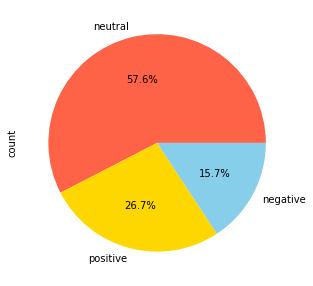

In [213]:
test = predictionFinal_mcu.groupBy('prediction').count()
test.show()
testdf = test.toPandas()
testdf.plot(legend=False, kind='pie', colors=['tomato', 'gold', 'skyblue'], figsize=(5,5), y='count', labels=labels, autopct='%1.1f%%')

In [214]:
char = predictionFinal_mcu.groupBy('character', 'prediction').count()
char.show(5)

+------------+----------+-----+
|   character|prediction|count|
+------------+----------+-----+
|JAMES RHODES|       1.0|   94|
|STEVE ROGERS|       0.0|  612|
|        THOR|       0.0|  501|
|  TONY STARK|       0.0|  957|
|PETER PARKER|       1.0|  116|
+------------+----------+-----+
only showing top 5 rows



In [215]:
df = char.toPandas()

In [228]:
newf = df.pivot(index='prediction', columns='character')
newf.columns = newf.columns.droplevel(0)
print(newf)

character   BRUCE BANNER  JAMES RHODES  LOKI  NATASHA ROMANOFF  NICK FURY  \
prediction                                                                  
0.0                  210           166   183               300        189   
1.0                  100            94    92               124        122   
2.0                   69            58    52                74         55   

character   PEPPER POTTS  PETER PARKER  STEVE ROGERS  THOR  TONY STARK  
prediction                                                              
0.0                  278           352           612   501         957  
1.0                   91           116           218   230         550  
2.0                   73            83           147   132         281  


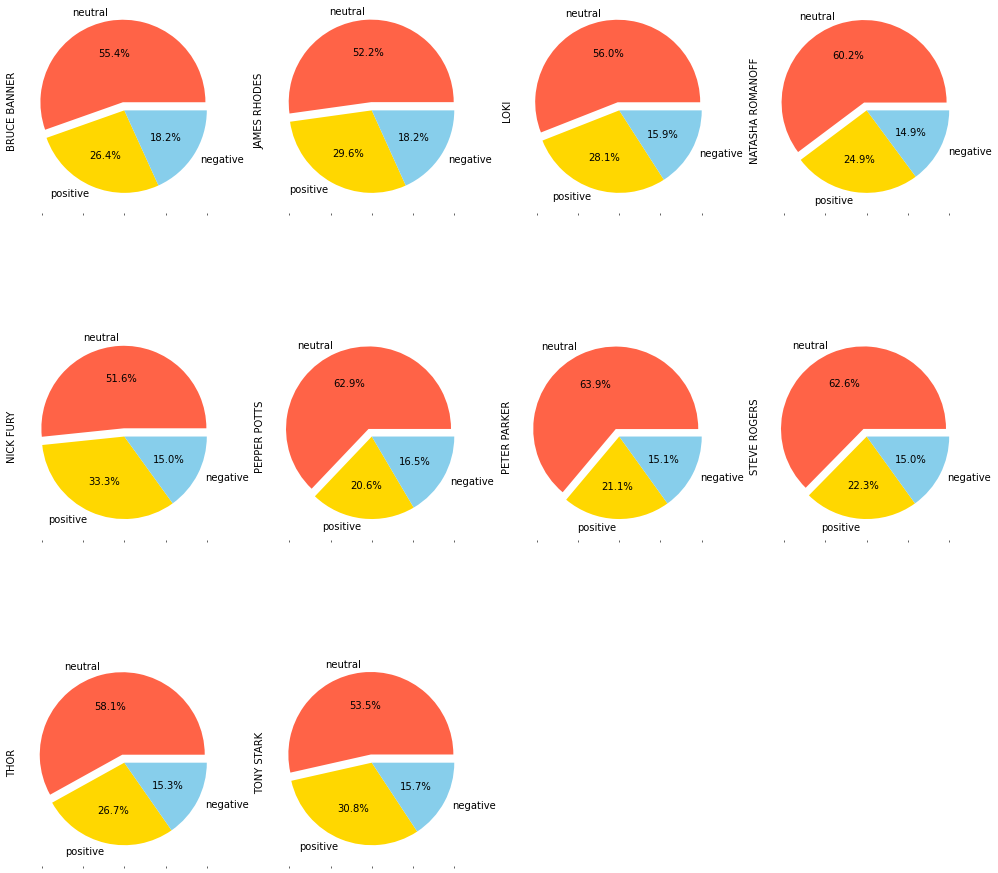

In [217]:

explodeTuple = (0.1,0,0)
char_pie = newf.plot(legend=False, labels=labels,explode=explodeTuple,kind='pie',subplots=True, colors=['tomato', 'gold', 'skyblue'], figsize=(17,17),layout=(3,4), autopct='%1.1f%%')

### What about the Vilains?

In [ ]:
vilains = []

In [245]:
movie = predictionFinal_mcu.groupBy('movie', 'prediction').count()
filtered_movie = movie.filter(movie['count'] > 3)
filtered_movie.show(100)

+--------------------+----------+-----+
|               movie|prediction|count|
+--------------------+----------+-----+
|          Iron Man 2|       0.0|  381|
|      Captain Marvel|       0.0|   80|
|Captain America: ...|       2.0|   42|
|Captain America: ...|       1.0|  121|
|            Iron Man|       2.0|   68|
|Avengers: Age of ...|       2.0|   77|
|Captain America: ...|       1.0|  114|
|          Iron Man 3|       1.0|  137|
|Spider-Man: Homec...|       1.0|  123|
|Avengers: Infinit...|       1.0|  109|
|Thor: The Dark World|       0.0|  146|
|            Iron Man|       0.0|  239|
|Captain America: ...|       0.0|  225|
|      Captain Marvel|       1.0|   36|
|Avengers: Age of ...|       1.0|  164|
|   Avengers: Endgame|       1.0|  144|
|          Iron Man 3|       0.0|  314|
|Thor: The Dark World|       2.0|   24|
|        The Avengers|       1.0|  187|
|Thor: The Dark World|       1.0|   64|
|      Thor: Ragnarok|       1.0|  117|
|                Thor|       1.0|   63|


In [246]:
n = filtered_movie.toPandas()
new_movie = n.pivot(index='prediction', columns='movie')
new_movie.columns = new_movie.columns.droplevel(0)

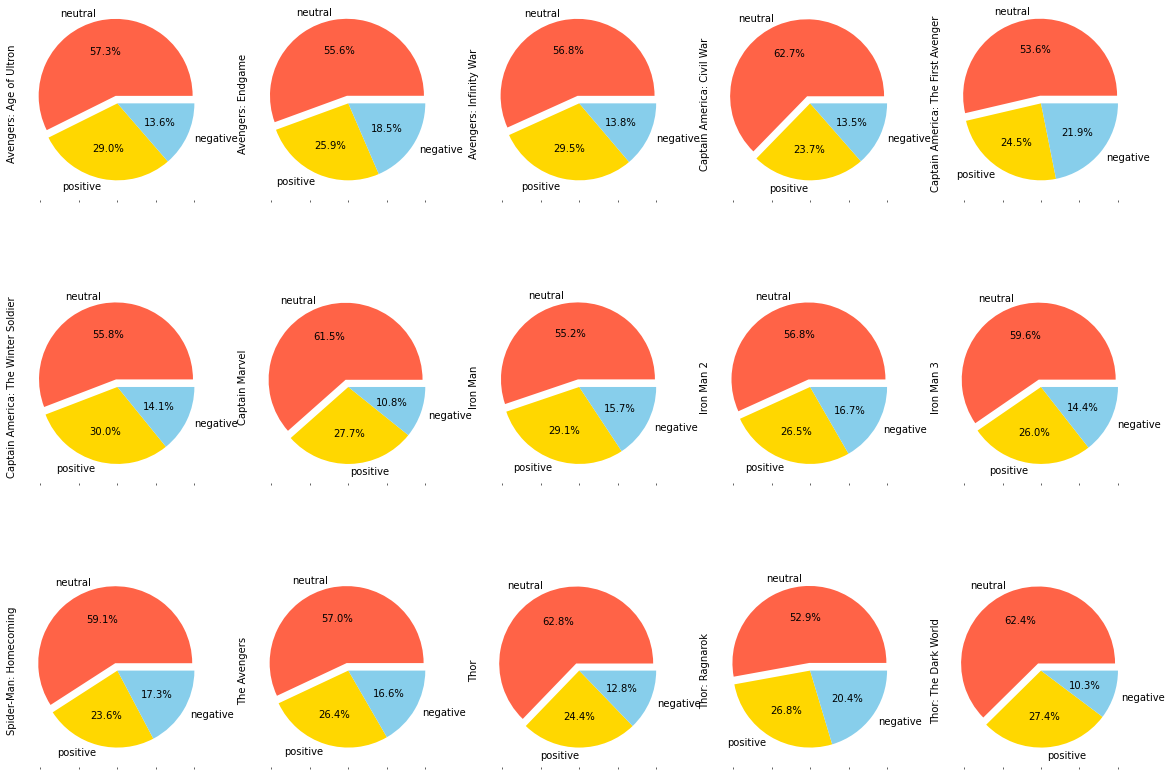

In [252]:

char_pie = new_movie.plot(labels=labels, explode=explodeTuple, legend=False,kind='pie',subplots=True, colors=['tomato', 'gold', 'skyblue'], figsize=(20,20),layout=(4,5), autopct='%1.1f%%')